In [1]:
import librosa #package for audio analysis
import pandas as pd # for data analysis
%matplotlib inline 
#this displays outputs inline, as is required for use in ipynb
import matplotlib.pyplot as plt #matplotlib is for embedding graph plots
import librosa.display 
from IPython.display import Audio 
import IPython.display as ipd  # To play sound in the notebook
import numpy as np #for larger mathematical calculations
import tensorflow as tf # ML library
from matplotlib.pyplot import specgram
import os # interface with underlying OS that python is running on
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import GridSearchCV
import keras 
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import soundfile as sf
from sklearn.model_selection import train_test_split
print('imported successfully')

imported successfully


In [2]:
# testing file load
x, sr = librosa.load('rdset/Actor_01/03-01-01-01-01-01-01.wav')
sf.write('Train/audio/FirstAudio.wav',x,sr)
Audio(data=x, rate=sr)

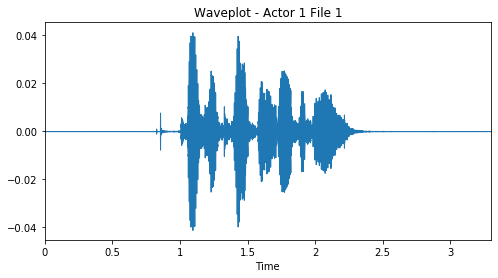

In [3]:
# waveplot generation test
plt.figure(figsize=(8, 4))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Actor 1 File 1')
plt.savefig('Train/wp/Waveplot_FirstAudio.png')

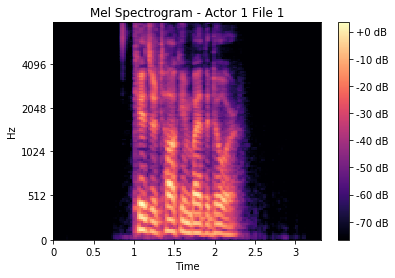

In [4]:
# mel generation test
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Actor 1 File 1')
plt.savefig('Train/melspec/MelSpec_FirstAudio.png')
plt.colorbar(format='%+2.0f dB');

In [5]:
# label creation for df
emotion = []
gender = []
actor = []
file_path = []
actor_set = os.listdir('rdset/') 
for i in actor_set:
    filename = os.listdir('rdset/' + i) 
    for f in filename: 
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        file_path.append('rdset/' + i + '/' + f)
# dataframe creation with labeled audio
audio_df = pd.DataFrame(emotion)
audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
audio_df = pd.concat([pd.DataFrame(gender),audio_df,pd.DataFrame(actor)],axis=1)
audio_df.columns = ['gender','emotion','actor']
audio_df = pd.concat([audio_df,pd.DataFrame(file_path, columns = ['path'])],axis=1)

In [6]:
audio_df

,gender,emotion,actor,path
0,male,neutral,1,rdset/Actor_01/03-01-01-01-01-01-01.wav
1,male,neutral,1,rdset/Actor_01/03-01-01-01-01-02-01.wav
2,male,neutral,1,rdset/Actor_01/03-01-01-01-02-01-01.wav
3,male,neutral,1,rdset/Actor_01/03-01-01-01-02-02-01.wav
4,male,calm,1,rdset/Actor_01/03-01-02-01-01-01-01.wav
...,...,...,...,...
1435,female,surprise,24,rdset/Actor_24/03-01-08-01-02-02-24.wav
1436,female,surprise,24,rdset/Actor_24/03-01-08-02-01-01-24.wav
1437,female,surprise,24,rdset/Actor_24/03-01-08-02-01-02-24.wav
1438,female,surprise,24,rdset/Actor_24/03-01-08-02-02-01-24.wav


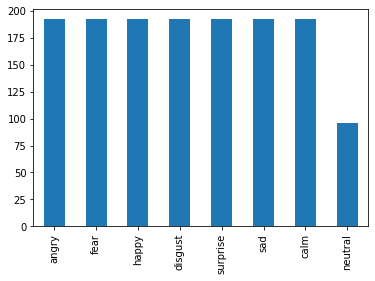

In [7]:
audio_df.emotion.value_counts().plot(kind='bar')

In [8]:
#export
audio_df.to_csv('Train/data/audio.csv')

In [9]:
# mel extraction of all files
df = pd.DataFrame(columns=['mel_spectrogram'])
counter=0
for index,path in enumerate(audio_df.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0)
    
    df.loc[counter] = [log_spectrogram]
    counter=counter+1
print(str(len(df)) + ' is length of melspec df')
df.head()

# labeled data for training
df_combined = pd.concat([audio_df,pd.DataFrame(df['mel_spectrogram'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)
df_combined.drop(columns='path',inplace=True)
df_combined.head()

1440 is length of melspec df


,gender,emotion,actor,0,1,2,3,4,5,6,...,249,250,251,252,253,254,255,256,257,258
0,male,neutral,1,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,-76.384773,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,male,neutral,1,-75.335518,-75.445320,-75.554031,-75.203949,-75.230530,-75.319374,-75.653793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,male,neutral,1,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male,neutral,1,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,-75.268448,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,male,calm,1,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,...,-80.147377,-80.147377,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377


In [10]:
#data prep 5 steps, iterate last few steps as required

In [11]:
#train, test split the data
train,test = train_test_split(df_combined, test_size=0.2, random_state=0, stratify=df_combined[['emotion','gender','actor']])

X_train = train.iloc[:, 3:]
y_train = train.iloc[:,:2].drop(columns=['gender'])
print("shape of train")
print(X_train.shape)
X_test = test.iloc[:,3:]
y_test = test.iloc[:,:2].drop(columns=['gender'])
print("shape of test")
print(X_test.shape)

shape of train
(1152, 259)
shape of test
(288, 259)


In [12]:
#normalise
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [13]:
#transform into arrays for keras
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [14]:
#one-hot encoding of target variable
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

D:\My Folders\Dev\Anaconda\New folder\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [16]:
#reshape for 3d checkpoint after model layer creation
#
#
#
#
#separator

In [17]:
#base

In [18]:
X_train.shape
X_test.shape

from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
DummyClassifier(strategy='stratified')
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

0.059027777777777776

In [19]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.3194444444444444

In [20]:
#initial

In [21]:
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 250, 64)           704       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 30, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128)            0

In [22]:
#reshape 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape

(1152, 259, 1)

In [23]:
#reiterate to clear for checkpointing
#BUILD 1D CNN LAYERS
model = tf.keras.Sequential()
model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(8)))
model.add(layers.Dropout(0.4))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(8, activation='sigmoid'))
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 250, 64)           704       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 30, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 128)           

In [24]:
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_test, y_test),callbacks=[checkpoint])

Epoch 1/40
36/36 [==============================] - ETA: 1:45 - loss: 3.0185 - accuracy: 0.09 - ETA: 2s - loss: 3.0097 - accuracy: 0.0703 - ETA: 2s - loss: 3.0037 - accuracy: 0.07 - ETA: 2s - loss: 2.9918 - accuracy: 0.07 - ETA: 2s - loss: 2.9815 - accuracy: 0.07 - ETA: 2s - loss: 2.9715 - accuracy: 0.08 - ETA: 2s - loss: 2.9620 - accuracy: 0.09 - ETA: 1s - loss: 2.9513 - accuracy: 0.09 - ETA: 1s - loss: 2.9415 - accuracy: 0.10 - ETA: 1s - loss: 2.9313 - accuracy: 0.10 - ETA: 1s - loss: 2.9210 - accuracy: 0.11 - ETA: 1s - loss: 2.9110 - accuracy: 0.11 - ETA: 1s - loss: 2.9011 - accuracy: 0.12 - ETA: 1s - loss: 2.8908 - accuracy: 0.12 - ETA: 1s - loss: 2.8798 - accuracy: 0.12 - ETA: 1s - loss: 2.8696 - accuracy: 0.13 - ETA: 1s - loss: 2.8600 - accuracy: 0.13 - ETA: 1s - loss: 2.8507 - accuracy: 0.14 - ETA: 1s - loss: 2.8416 - accuracy: 0.14 - ETA: 1s - loss: 2.8329 - accuracy: 0.14 - ETA: 1s - loss: 2.8245 - accuracy: 0.14 - ETA: 1s - loss: 2.8162 - accuracy: 0.15 - ETA: 0s - loss: 2.80

36/36 [==============================] - ETA: 2s - loss: 1.5657 - accuracy: 0.43 - ETA: 3s - loss: 1.5710 - accuracy: 0.42 - ETA: 3s - loss: 1.6188 - accuracy: 0.41 - ETA: 2s - loss: 1.6543 - accuracy: 0.40 - ETA: 2s - loss: 1.6784 - accuracy: 0.39 - ETA: 2s - loss: 1.6913 - accuracy: 0.38 - ETA: 2s - loss: 1.6986 - accuracy: 0.37 - ETA: 2s - loss: 1.7037 - accuracy: 0.37 - ETA: 2s - loss: 1.7069 - accuracy: 0.36 - ETA: 2s - loss: 1.7096 - accuracy: 0.36 - ETA: 2s - loss: 1.7128 - accuracy: 0.36 - ETA: 1s - loss: 1.7133 - accuracy: 0.36 - ETA: 1s - loss: 1.7142 - accuracy: 0.35 - ETA: 1s - loss: 1.7162 - accuracy: 0.35 - ETA: 1s - loss: 1.7177 - accuracy: 0.35 - ETA: 1s - loss: 1.7194 - accuracy: 0.35 - ETA: 1s - loss: 1.7208 - accuracy: 0.35 - ETA: 1s - loss: 1.7222 - accuracy: 0.35 - ETA: 1s - loss: 1.7237 - accuracy: 0.35 - ETA: 1s - loss: 1.7249 - accuracy: 0.35 - ETA: 1s - loss: 1.7259 - accuracy: 0.35 - ETA: 1s - loss: 1.7265 - accuracy: 0.35 - ETA: 1s - loss: 1.7270 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.8391 - accuracy: 0.28 - ETA: 2s - loss: 1.7574 - accuracy: 0.32 - ETA: 2s - loss: 1.7248 - accuracy: 0.35 - ETA: 2s - loss: 1.6938 - accuracy: 0.36 - ETA: 2s - loss: 1.6765 - accuracy: 0.37 - ETA: 2s - loss: 1.6625 - accuracy: 0.38 - ETA: 2s - loss: 1.6560 - accuracy: 0.38 - ETA: 2s - loss: 1.6485 - accuracy: 0.39 - ETA: 2s - loss: 1.6415 - accuracy: 0.39 - ETA: 2s - loss: 1.6365 - accuracy: 0.39 - ETA: 1s - loss: 1.6324 - accuracy: 0.39 - ETA: 1s - loss: 1.6300 - accuracy: 0.39 - ETA: 1s - loss: 1.6294 - accuracy: 0.39 - ETA: 1s - loss: 1.6300 - accuracy: 0.39 - ETA: 1s - loss: 1.6304 - accuracy: 0.39 - ETA: 1s - loss: 1.6304 - accuracy: 0.39 - ETA: 1s - loss: 1.6309 - accuracy: 0.39 - ETA: 1s - loss: 1.6308 - accuracy: 0.39 - ETA: 1s - loss: 1.6308 - accuracy: 0.39 - ETA: 1s - loss: 1.6303 - accuracy: 0.39 - ETA: 1s - loss: 1.6299 - accuracy: 0.39 - ETA: 1s - loss: 1.6296 - accuracy: 0.39 - ETA: 1s - loss: 1.6296 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.5023 - accuracy: 0.46 - ETA: 2s - loss: 1.4934 - accuracy: 0.46 - ETA: 2s - loss: 1.4902 - accuracy: 0.46 - ETA: 2s - loss: 1.5016 - accuracy: 0.46 - ETA: 2s - loss: 1.5068 - accuracy: 0.46 - ETA: 2s - loss: 1.5171 - accuracy: 0.46 - ETA: 2s - loss: 1.5220 - accuracy: 0.45 - ETA: 2s - loss: 1.5245 - accuracy: 0.45 - ETA: 2s - loss: 1.5269 - accuracy: 0.45 - ETA: 2s - loss: 1.5322 - accuracy: 0.45 - ETA: 1s - loss: 1.5381 - accuracy: 0.44 - ETA: 1s - loss: 1.5417 - accuracy: 0.44 - ETA: 1s - loss: 1.5445 - accuracy: 0.44 - ETA: 1s - loss: 1.5461 - accuracy: 0.44 - ETA: 1s - loss: 1.5483 - accuracy: 0.44 - ETA: 1s - loss: 1.5494 - accuracy: 0.44 - ETA: 1s - loss: 1.5512 - accuracy: 0.44 - ETA: 1s - loss: 1.5519 - accuracy: 0.44 - ETA: 1s - loss: 1.5518 - accuracy: 0.44 - ETA: 1s - loss: 1.5522 - accuracy: 0.44 - ETA: 1s - loss: 1.5528 - accuracy: 0.44 - ETA: 1s - loss: 1.5532 - accuracy: 0.44 - ETA: 1s - loss: 1.5537 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.4796 - accuracy: 0.53 - ETA: 2s - loss: 1.5104 - accuracy: 0.49 - ETA: 2s - loss: 1.5251 - accuracy: 0.48 - ETA: 2s - loss: 1.5248 - accuracy: 0.47 - ETA: 2s - loss: 1.5319 - accuracy: 0.46 - ETA: 2s - loss: 1.5344 - accuracy: 0.45 - ETA: 2s - loss: 1.5348 - accuracy: 0.45 - ETA: 2s - loss: 1.5355 - accuracy: 0.44 - ETA: 2s - loss: 1.5366 - accuracy: 0.44 - ETA: 2s - loss: 1.5374 - accuracy: 0.43 - ETA: 1s - loss: 1.5373 - accuracy: 0.43 - ETA: 1s - loss: 1.5371 - accuracy: 0.43 - ETA: 1s - loss: 1.5375 - accuracy: 0.43 - ETA: 1s - loss: 1.5381 - accuracy: 0.43 - ETA: 1s - loss: 1.5386 - accuracy: 0.43 - ETA: 1s - loss: 1.5398 - accuracy: 0.42 - ETA: 1s - loss: 1.5403 - accuracy: 0.42 - ETA: 1s - loss: 1.5404 - accuracy: 0.42 - ETA: 1s - loss: 1.5400 - accuracy: 0.42 - ETA: 1s - loss: 1.5399 - accuracy: 0.42 - ETA: 1s - loss: 1.5395 - accuracy: 0.42 - ETA: 1s - loss: 1.5388 - accuracy: 0.42 - ETA: 1s - loss: 1.5378 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.0655 - accuracy: 0.68 - ETA: 2s - loss: 1.1521 - accuracy: 0.64 - ETA: 2s - loss: 1.2004 - accuracy: 0.61 - ETA: 2s - loss: 1.2442 - accuracy: 0.59 - ETA: 2s - loss: 1.2668 - accuracy: 0.57 - ETA: 2s - loss: 1.2837 - accuracy: 0.56 - ETA: 2s - loss: 1.2968 - accuracy: 0.56 - ETA: 1s - loss: 1.3085 - accuracy: 0.55 - ETA: 1s - loss: 1.3184 - accuracy: 0.54 - ETA: 1s - loss: 1.3252 - accuracy: 0.54 - ETA: 1s - loss: 1.3326 - accuracy: 0.53 - ETA: 1s - loss: 1.3403 - accuracy: 0.53 - ETA: 1s - loss: 1.3480 - accuracy: 0.52 - ETA: 1s - loss: 1.3548 - accuracy: 0.52 - ETA: 1s - loss: 1.3613 - accuracy: 0.51 - ETA: 1s - loss: 1.3666 - accuracy: 0.51 - ETA: 1s - loss: 1.3720 - accuracy: 0.51 - ETA: 1s - loss: 1.3768 - accuracy: 0.50 - ETA: 1s - loss: 1.3801 - accuracy: 0.50 - ETA: 1s - loss: 1.3824 - accuracy: 0.50 - ETA: 1s - loss: 1.3846 - accuracy: 0.50 - ETA: 1s - loss: 1.3864 - accuracy: 0.50 - ETA: 0s - loss: 1.3880 - accuracy: 

36/36 [==============================] - ETA: 3s - loss: 0.8654 - accuracy: 0.62 - ETA: 3s - loss: 0.9889 - accuracy: 0.60 - ETA: 3s - loss: 1.0715 - accuracy: 0.57 - ETA: 3s - loss: 1.1271 - accuracy: 0.56 - ETA: 3s - loss: 1.1669 - accuracy: 0.55 - ETA: 3s - loss: 1.1890 - accuracy: 0.54 - ETA: 2s - loss: 1.2029 - accuracy: 0.54 - ETA: 2s - loss: 1.2120 - accuracy: 0.53 - ETA: 2s - loss: 1.2221 - accuracy: 0.53 - ETA: 2s - loss: 1.2303 - accuracy: 0.53 - ETA: 2s - loss: 1.2361 - accuracy: 0.53 - ETA: 2s - loss: 1.2436 - accuracy: 0.53 - ETA: 2s - loss: 1.2495 - accuracy: 0.52 - ETA: 2s - loss: 1.2546 - accuracy: 0.52 - ETA: 1s - loss: 1.2598 - accuracy: 0.52 - ETA: 1s - loss: 1.2654 - accuracy: 0.52 - ETA: 1s - loss: 1.2704 - accuracy: 0.52 - ETA: 1s - loss: 1.2750 - accuracy: 0.52 - ETA: 1s - loss: 1.2799 - accuracy: 0.52 - ETA: 1s - loss: 1.2843 - accuracy: 0.51 - ETA: 1s - loss: 1.2878 - accuracy: 0.51 - ETA: 1s - loss: 1.2911 - accuracy: 0.51 - ETA: 1s - loss: 1.2941 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.4145 - accuracy: 0.53 - ETA: 2s - loss: 1.4187 - accuracy: 0.52 - ETA: 2s - loss: 1.3885 - accuracy: 0.52 - ETA: 2s - loss: 1.3759 - accuracy: 0.51 - ETA: 2s - loss: 1.3663 - accuracy: 0.51 - ETA: 2s - loss: 1.3593 - accuracy: 0.51 - ETA: 2s - loss: 1.3557 - accuracy: 0.50 - ETA: 2s - loss: 1.3508 - accuracy: 0.50 - ETA: 2s - loss: 1.3447 - accuracy: 0.50 - ETA: 2s - loss: 1.3408 - accuracy: 0.49 - ETA: 2s - loss: 1.3377 - accuracy: 0.49 - ETA: 2s - loss: 1.3350 - accuracy: 0.49 - ETA: 2s - loss: 1.3348 - accuracy: 0.49 - ETA: 1s - loss: 1.3338 - accuracy: 0.49 - ETA: 1s - loss: 1.3331 - accuracy: 0.49 - ETA: 1s - loss: 1.3330 - accuracy: 0.49 - ETA: 1s - loss: 1.3326 - accuracy: 0.50 - ETA: 1s - loss: 1.3326 - accuracy: 0.50 - ETA: 1s - loss: 1.3322 - accuracy: 0.50 - ETA: 1s - loss: 1.3320 - accuracy: 0.50 - ETA: 1s - loss: 1.3318 - accuracy: 0.50 - ETA: 1s - loss: 1.3315 - accuracy: 0.50 - ETA: 1s - loss: 1.3312 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.3887 - accuracy: 0.46 - ETA: 2s - loss: 1.3770 - accuracy: 0.46 - ETA: 2s - loss: 1.3596 - accuracy: 0.47 - ETA: 2s - loss: 1.3545 - accuracy: 0.47 - ETA: 2s - loss: 1.3493 - accuracy: 0.47 - ETA: 2s - loss: 1.3424 - accuracy: 0.48 - ETA: 2s - loss: 1.3297 - accuracy: 0.49 - ETA: 2s - loss: 1.3182 - accuracy: 0.49 - ETA: 2s - loss: 1.3083 - accuracy: 0.50 - ETA: 2s - loss: 1.2983 - accuracy: 0.51 - ETA: 2s - loss: 1.2887 - accuracy: 0.51 - ETA: 2s - loss: 1.2807 - accuracy: 0.52 - ETA: 1s - loss: 1.2744 - accuracy: 0.52 - ETA: 1s - loss: 1.2695 - accuracy: 0.53 - ETA: 1s - loss: 1.2657 - accuracy: 0.53 - ETA: 1s - loss: 1.2618 - accuracy: 0.53 - ETA: 1s - loss: 1.2584 - accuracy: 0.53 - ETA: 1s - loss: 1.2553 - accuracy: 0.53 - ETA: 1s - loss: 1.2527 - accuracy: 0.54 - ETA: 1s - loss: 1.2514 - accuracy: 0.54 - ETA: 1s - loss: 1.2497 - accuracy: 0.54 - ETA: 1s - loss: 1.2483 - accuracy: 0.54 - ETA: 1s - loss: 1.2476 - accuracy: 

36/36 [==============================] - ETA: 2s - loss: 1.1301 - accuracy: 0.68 - ETA: 2s - loss: 1.1814 - accuracy: 0.63 - ETA: 2s - loss: 1.1863 - accuracy: 0.62 - ETA: 2s - loss: 1.1899 - accuracy: 0.61 - ETA: 2s - loss: 1.1814 - accuracy: 0.61 - ETA: 2s - loss: 1.1767 - accuracy: 0.60 - ETA: 2s - loss: 1.1725 - accuracy: 0.60 - ETA: 2s - loss: 1.1676 - accuracy: 0.60 - ETA: 2s - loss: 1.1644 - accuracy: 0.60 - ETA: 2s - loss: 1.1625 - accuracy: 0.60 - ETA: 2s - loss: 1.1613 - accuracy: 0.60 - ETA: 1s - loss: 1.1623 - accuracy: 0.60 - ETA: 1s - loss: 1.1633 - accuracy: 0.59 - ETA: 1s - loss: 1.1653 - accuracy: 0.59 - ETA: 1s - loss: 1.1675 - accuracy: 0.59 - ETA: 1s - loss: 1.1696 - accuracy: 0.59 - ETA: 1s - loss: 1.1711 - accuracy: 0.58 - ETA: 1s - loss: 1.1729 - accuracy: 0.58 - ETA: 1s - loss: 1.1753 - accuracy: 0.58 - ETA: 1s - loss: 1.1773 - accuracy: 0.58 - ETA: 1s - loss: 1.1788 - accuracy: 0.58 - ETA: 1s - loss: 1.1804 - accuracy: 0.58 - ETA: 1s - loss: 1.1821 - accuracy: 

In [27]:
#saving model, keras lib
model.save('mymodel')
model.save('update.h5')
model_json = model.to_json()
with open("update.json", "w") as json_file:
  json_file.write(model_json)
print('success')

INFO:tensorflow:Assets written to: mymodel\assets
success
